In [2]:
import pandas as pd
import numpy as np
import math
import json
import os

from KDEpy import FFTKDE
from scipy import stats
from scipy.signal import argrelextrema, argrelmin

from tqdm import tqdm

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(rc={'figure.figsize':(24, 15)}, font_scale=2)

from glob import glob

import sys
sys.path.append('../')
import utils

# Cluster KDE

In [68]:
path = "../synthetic_data/testing/"
regions_df = pd.read_pickle(path + 'regions_df.pickle')
df = pd.read_pickle(path + 'df.pickle').sort_values(by='unix_time')
clusters_df = pd.read_pickle(path + 'clusters_df.pickle').sort_values(by='area', ascending=False)

df

,time,timestamp,measure,signal,noise,is_outlier,outlier_type,region_id,yhat,yhat_lower,...,unix_time,cluster_id,start,end,point_start,point_end,time_length,num_points,area,area_pts
0,0.000000,2020-06-01 00:00:00,0.029163,0.000000e+00,0.029163,0,NaN,NaN,0.009249,-0.216194,...,1.590970e+09,0.0,1.590970e+09,1.591108e+09,1.591009e+09,1.591009e+09,137990.872714,1,0.001093,0.000000
1,0.037404,2020-06-01 01:00:00,-0.103883,3.739490e-02,-0.141278,0,NaN,NaN,0.046699,-0.198172,...,1.590973e+09,0.0,1.590970e+09,1.591108e+09,1.591009e+09,1.591009e+09,137990.872714,1,0.001093,0.000000
2,0.074807,2020-06-01 02:00:00,0.115175,7.473749e-02,0.040437,0,NaN,NaN,0.084085,-0.166758,...,1.590977e+09,0.0,1.590970e+09,1.591108e+09,1.591009e+09,1.591009e+09,137990.872714,1,0.001093,0.000000
3,0.112211,2020-06-01 03:00:00,0.109561,1.119755e-01,-0.002414,0,NaN,NaN,0.121358,-0.125994,...,1.590980e+09,0.0,1.590970e+09,1.591108e+09,1.591009e+09,1.591009e+09,137990.872714,1,0.001093,0.000000
4,0.149614,2020-06-01 04:00:00,0.241070,1.490569e-01,0.092013,0,NaN,NaN,0.158466,-0.079614,...,1.590984e+09,0.0,1.590970e+09,1.591108e+09,1.591009e+09,1.591009e+09,137990.872714,1,0.001093,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,376.841504,2021-07-25 19:00:00,-0.127586,-1.490569e-01,0.021470,0,NaN,NaN,-0.169018,-0.416850,...,1.627240e+09,73.0,1.626673e+09,1.627254e+09,1.626692e+09,1.626930e+09,580761.586031,7,0.013442,0.007498
10076,376.878908,2021-07-25 20:00:00,-0.039870,-1.119755e-01,0.072106,0,NaN,NaN,-0.132019,-0.379271,...,1.627243e+09,73.0,1.626673e+09,1.627254e+09,1.626692e+09,1.626930e+09,580761.586031,7,0.013442,0.007498
10077,376.916311,2021-07-25 21:00:00,0.040002,-7.473749e-02,0.114740,0,NaN,NaN,-0.094831,-0.345396,...,1.627247e+09,73.0,1.626673e+09,1.627254e+09,1.626692e+09,1.626930e+09,580761.586031,7,0.013442,0.007498
10078,376.953715,2021-07-25 22:00:00,0.031125,-3.739490e-02,0.068520,0,NaN,NaN,-0.057505,-0.298523,...,1.627250e+09,73.0,1.626673e+09,1.627254e+09,1.626692e+09,1.626930e+09,580761.586031,7,0.013442,0.007498


In [69]:
def get_outlier_timestamps(df):
    outliers_df = df.copy()[df['raw_voting_score'] > 0]
    outliers = []
    # Each vote adds one point (a timestamp with more than 1 votes is added more than once)
    for _, row in outliers_df.iterrows():
        outliers += [row["unix_time"]] * row['raw_voting_score']
    return outliers

def get_bandwidth(points, n, alpha=5):
    exponent = -1 / alpha
    return 1.06*np.std(points)*(n**exponent)

def clusterKDE(points, alpha=5):
    points_set = set(points)
    clusters_dict = {}
    n=len(points)

    cluster_id = 0
    while len(points_set) != 0:
        cluster_id += 1
        h = get_bandwidth(points, n, alpha)
        print("Bandwidth:", h)
        break

In [70]:
outliers = get_outlier_timestamps(df)
print("STD:", np.std(outliers))

clusterKDE(outliers, alpha=5)

STD: 10572034.254470082
Bandwidth: 3150953.3509654296


# KDE Bandwidth using Improved Sheather-Jones (ISJ)

## Functions

In [3]:
# KDE Bandwidth using ISJ Functions

def get_outlier_timestamps(df):
    '''
    Given a dataframe `df` of the processed time series return as a numpy array the timestamps of all detected outliers

    If a timestamps corresponds to an outlier from multiple views then the timestamp is repeated for each view 
    (i.e, there can be repetitions of the same timestamp)
    '''
    # Get the timestamps of all outliers
    outliers_df = df.copy()[df['raw_voting_score'] > 0]
    points = []
    
    # Each vote adds one point (a timestamp with more than 1 votes is added more than once)
    for _, row in outliers_df.iterrows():
        points += [row["unix_time"]] * row['raw_voting_score']

    return np.array(points)

def get_local_minima(arr):
    '''
    Given a list `arr` find its local minima.
    If there are flat minima present then only pick the boundaries of the minima flat regions
    '''
    minima_all = argrelextrema(arr, np.less_equal)[0]

    # Refine the minima list to avoid flat minima
    minima = []
    for min_idx in minima_all:
        # Loop over indices that aren't at the boundaries of the input list
        if ((min_idx > 0) and (min_idx < (len(arr) - 1))):
            if arr[min_idx -1] != arr[min_idx + 1]:
                minima.append(min_idx)
    
    return minima

def get_kde_isj_density_df(df):
    '''
    Run KDE over the timeseries in `df` using Improved Sheather-Jones (ISJ) bandwidth selection

    Returns a dataframe with the density
    '''
    # Get a list of the outlier timestamps
    outlier_timestamps = get_outlier_timestamps(df)

    # Sample the timestamps for which we estimate the density (use 3X num points of the df)
    samples = np.linspace(df['unix_time'].min(),df['unix_time'].max(), num=3*len(df.index))

    # Co                                                                                                                                                                                                                                                                                                                                                                    mpute density estimates using 'ISJ' - Improved Sheather Jones
    density = FFTKDE(kernel='epa', bw='ISJ').fit(outlier_timestamps).evaluate(samples)

    # Create the density_df
    density_df = pd.DataFrame({'unix_time': samples, 'density': density})
    density_df['timestamp'] = pd.to_datetime(density_df['unix_time'], unit='s')
    return density_df

def get_isj_clusters_df(density_df, df):
    mi = get_local_minima(density_df['density'].values)
    clusters_df_ISJ = utils.clustering.get_clusters_df(
        samples=density_df['unix_time'].values, density_dist=density_df['density'].values, minima_idx_list=mi,
        points=get_outlier_timestamps(df)
    )
    clusters_df_ISJ = clusters_df_ISJ.sort_values(by='area', ascending=False)
    return clusters_df_ISJ

def get_timeseries_and_density_figure(df, density, clusters, k):
    df = df.sort_values(by='timestamp')

    k_clusters = clusters.sort_values(by='area', ascending=False).head(k).reset_index()
    k_clusters

    # Plot the Figure
    fig, axs = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0)

    axs[0].plot(df['unix_time'], df['measure'])
    axs[0].scatter(df[df['is_outlier']==1]['unix_time'].values, df[df['is_outlier']==1]['measure'].values, s=90, c='red', zorder=10, label='True Injected Outliers')
    axs[0].scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')
    axs[0].set_ylabel('Measure');axs[0].legend()

    # Plot the alert regions
    for _, alert in k_clusters.iterrows():
        axs[0].add_patch(patches.Rectangle((alert['start'], -1.5), width=alert['end']-alert['start'], height=3, linewidth=0, color='yellow', zorder=10, alpha=0.40))

    axs[1].plot(density['unix_time'], density['density'])
    axs[1].set_ylabel('Density');axs[1].set_xlabel('Unix Time')
    for idx, alert in k_clusters.iterrows():
        axs[1].add_patch(patches.Rectangle((alert['start'], 0), width=alert['end']-alert['start'], height=density['density'].max(), linewidth=0, color='yellow', zorder=10, alpha=0.40))
        x_loc = alert['start'] + (alert['end'] - alert['start'])/2
        axs[1].text(x=x_loc, y=density['density'].max(), s=str(idx+1), fontsize=12, color='red', horizontalalignment='center')

    plt.tight_layout()
    plt.close()

    return fig

In [4]:
# Evaluation Related Functions

def get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=False):
    '''
    Given the `regions_df` and the `clusters_df` extract the real and predicted anomalous regions
    
    Notice that the predicted anomalous regions are set to be equal to the number of the true regions
    and the order they are picked is specified by the order of the rows in the `clusters_df`
    '''
    # Extract the real anomaly ranges and the predicted anomaly ranges
    real_ranges = []
    predicted_ranges = []
    for _, row in regions_df.iterrows():
        real_ranges.append([row['unix_start'], row['unix_end']])
    for _, row in clusters_df.iterrows():
        if cluster_points_bounds:
            predicted_ranges.append([row['point_start'], row['point_end']])
        else:
            predicted_ranges.append([row['start'], row['end']])
    predicted_ranges = predicted_ranges[:len(real_ranges)]

    return real_ranges, predicted_ranges

## Illustrative Example

In [5]:
path = "../synthetic_data/synthetic_experiments/all_outlier_types_098/seed2/"
regions_df = pd.read_pickle(path + 'regions_df.pickle')
df = pd.read_pickle(path + 'df.pickle').sort_values(by='unix_time')
clusters_df = pd.read_pickle(path + 'clusters_df.pickle').sort_values(by='area', ascending=False)
density_df = pd.read_pickle(path + 'density_df.pickle')

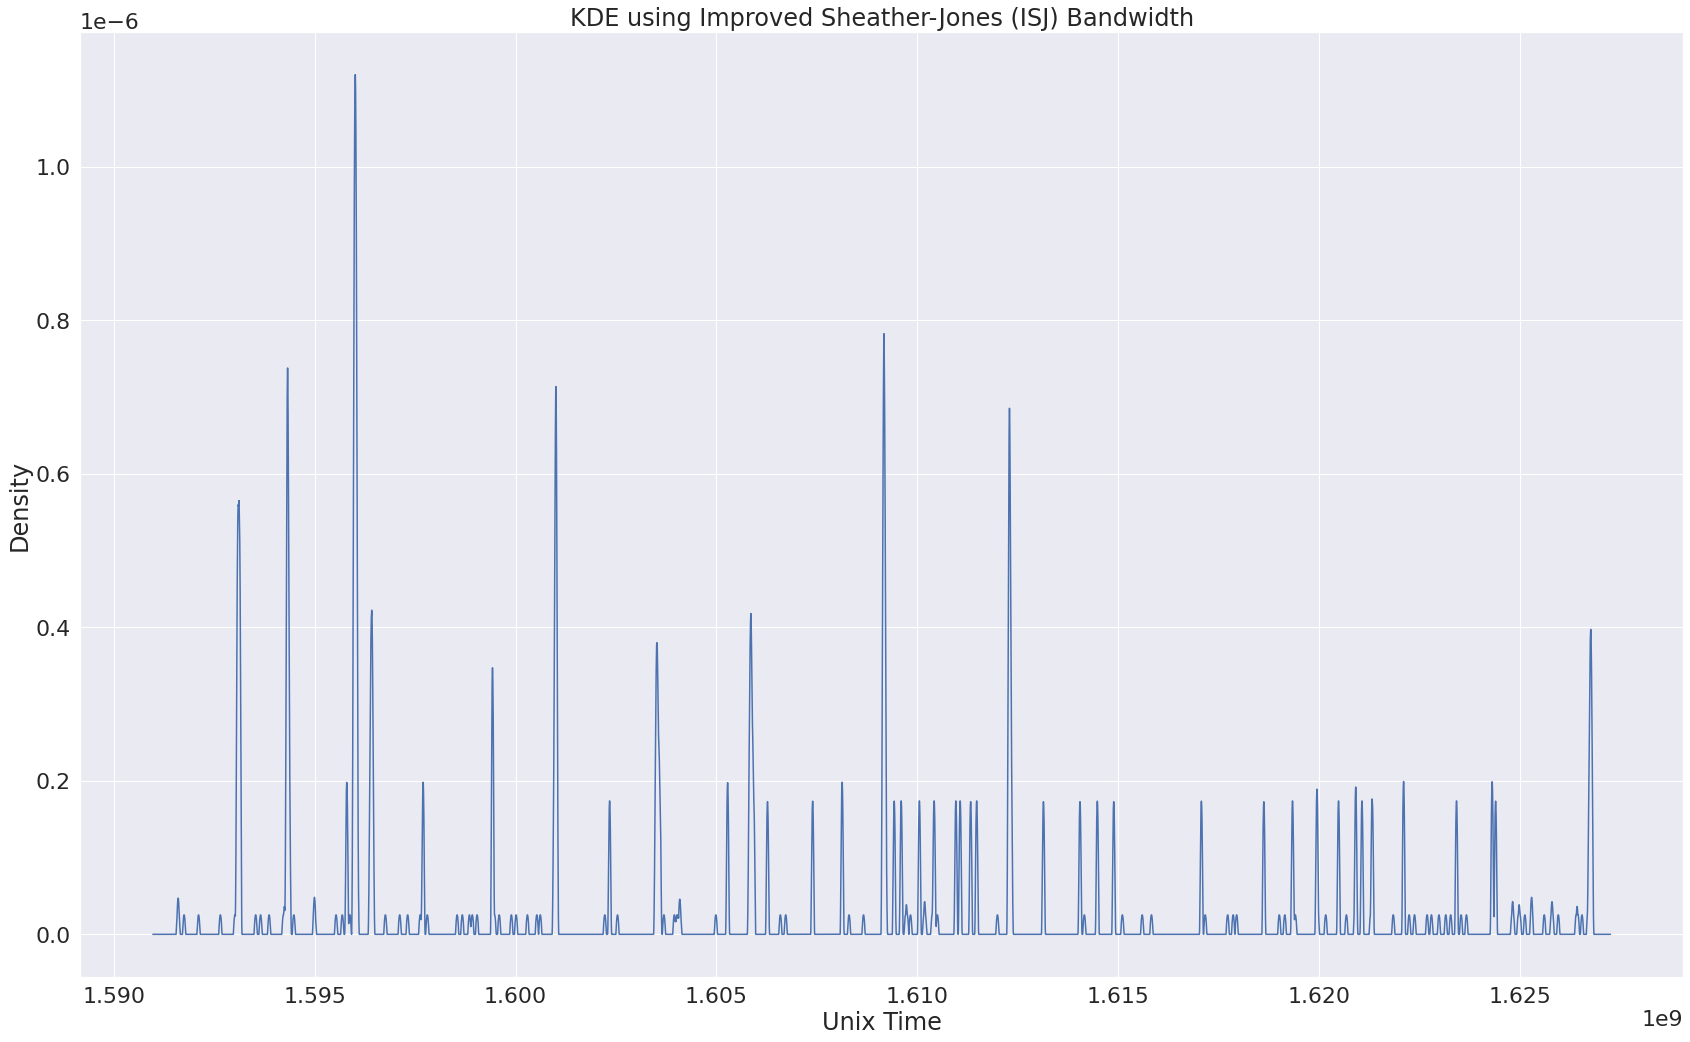

In [6]:
density_df_ISJ = get_kde_isj_density_df(df)
plt.plot(density_df_ISJ['unix_time'], density_df_ISJ['density'])
plt.xlabel('Unix Time');plt.ylabel('Density');plt.title('KDE using Improved Sheather-Jones (ISJ) Bandwidth');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/improved_sheather_jones/example_KDE_using_ISJ.svg')

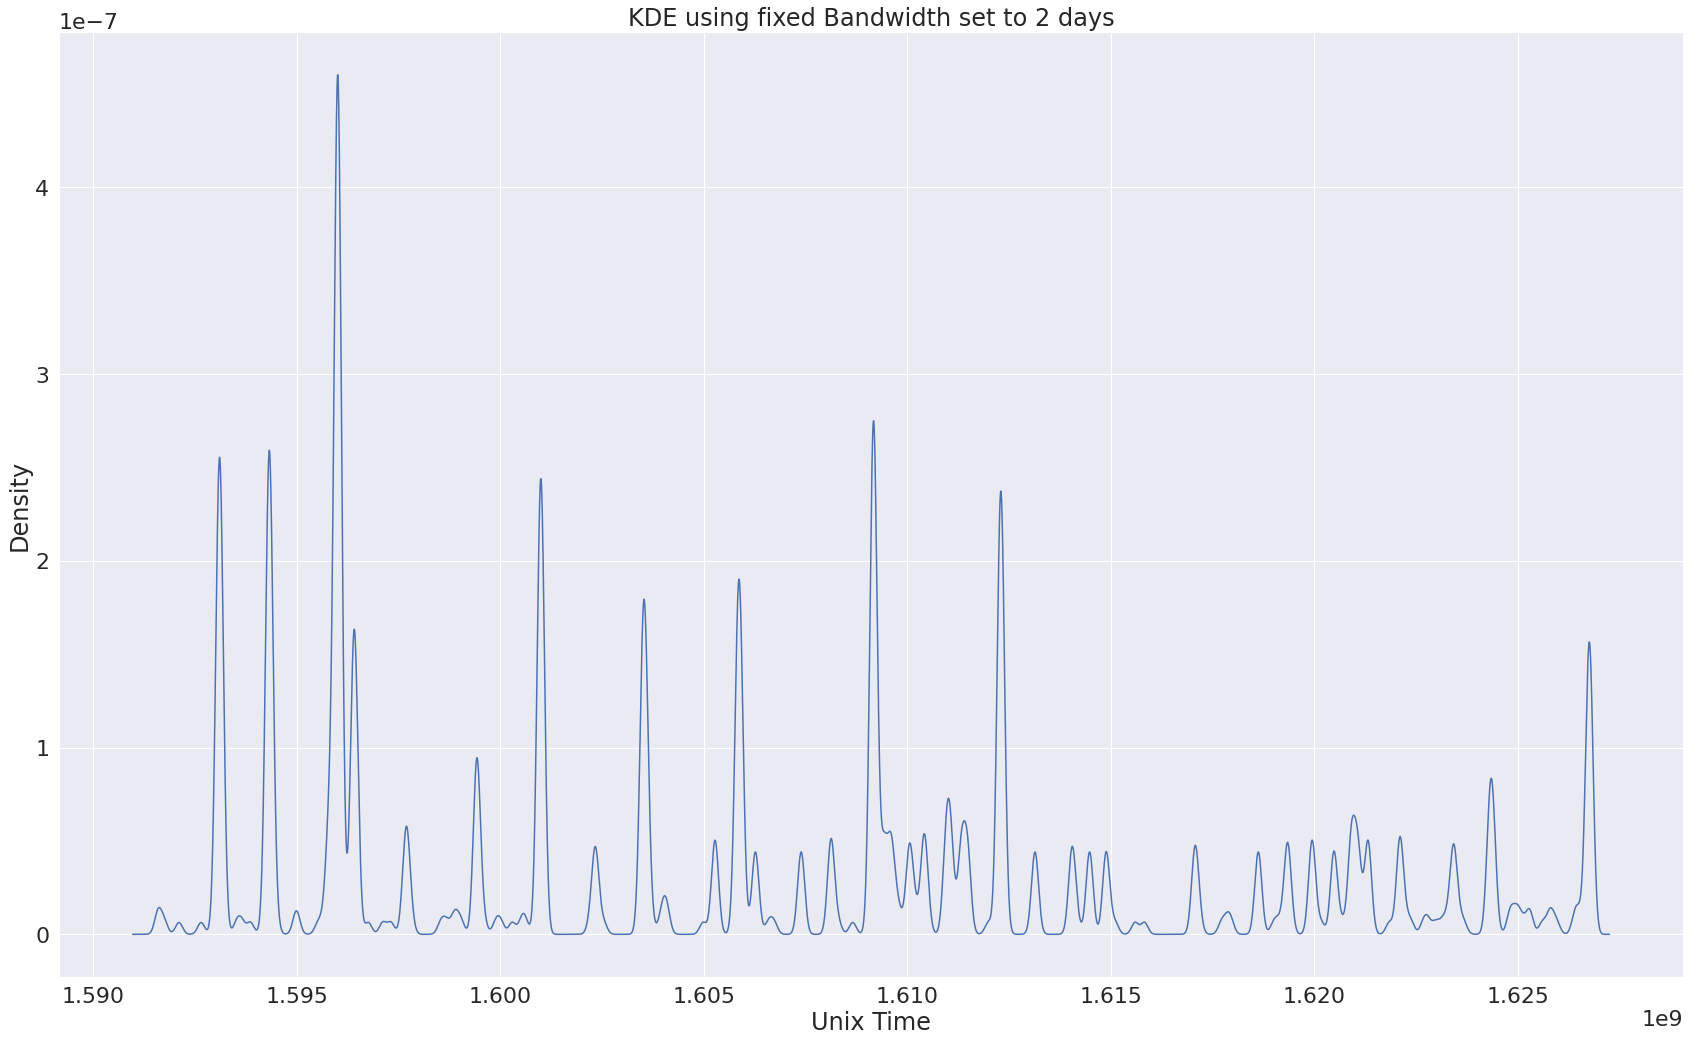

In [7]:
plt.plot(density_df['unix_time'], density_df['density'])
plt.xlabel('Unix Time');plt.ylabel('Density');plt.title('KDE using fixed Bandwidth set to 2 days');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/improved_sheather_jones/example_KDE_using_fixed_bandwidth.svg')

In [8]:
# Compute the clusters df for density_df_ISJ
clusters_df_ISJ = get_isj_clusters_df(density_df_ISJ, df)
clusters_df_ISJ

,cluster_id,start,end,point_start,point_end,time_length,num_points,area,area_pts
21,37,1.595918e+09,1.596109e+09,1.595959e+09,1.596067e+09,190787.380535,76,0.103971,0.092507
62,116,1.609094e+09,1.609260e+09,1.609135e+09,1.609218e+09,165589.047257,45,0.061562,0.050556
14,24,1.594255e+09,1.594421e+09,1.594264e+09,1.594379e+09,165589.047257,42,0.057010,0.053390
42,77,1.600907e+09,1.601073e+09,1.600949e+09,1.601032e+09,165589.047257,40,0.054721,0.044691
76,142,1.612226e+09,1.612392e+09,1.612267e+09,1.612350e+09,165589.047257,39,0.053354,0.042525
...,...,...,...,...,...,...,...,...,...
4,9,1.592973e+09,1.593024e+09,1.593014e+09,1.593014e+09,50396.666557,1,0.000891,0.000000
124,236,1.626442e+09,1.626485e+09,1.626444e+09,1.626444e+09,43197.142763,1,0.000743,0.000000
35,63,1.599475e+09,1.599518e+09,1.599476e+09,1.599476e+09,43197.142763,1,0.000728,0.000000
123,234,1.626359e+09,1.626403e+09,1.626401e+09,1.626401e+09,44397.063395,1,0.000716,0.000000


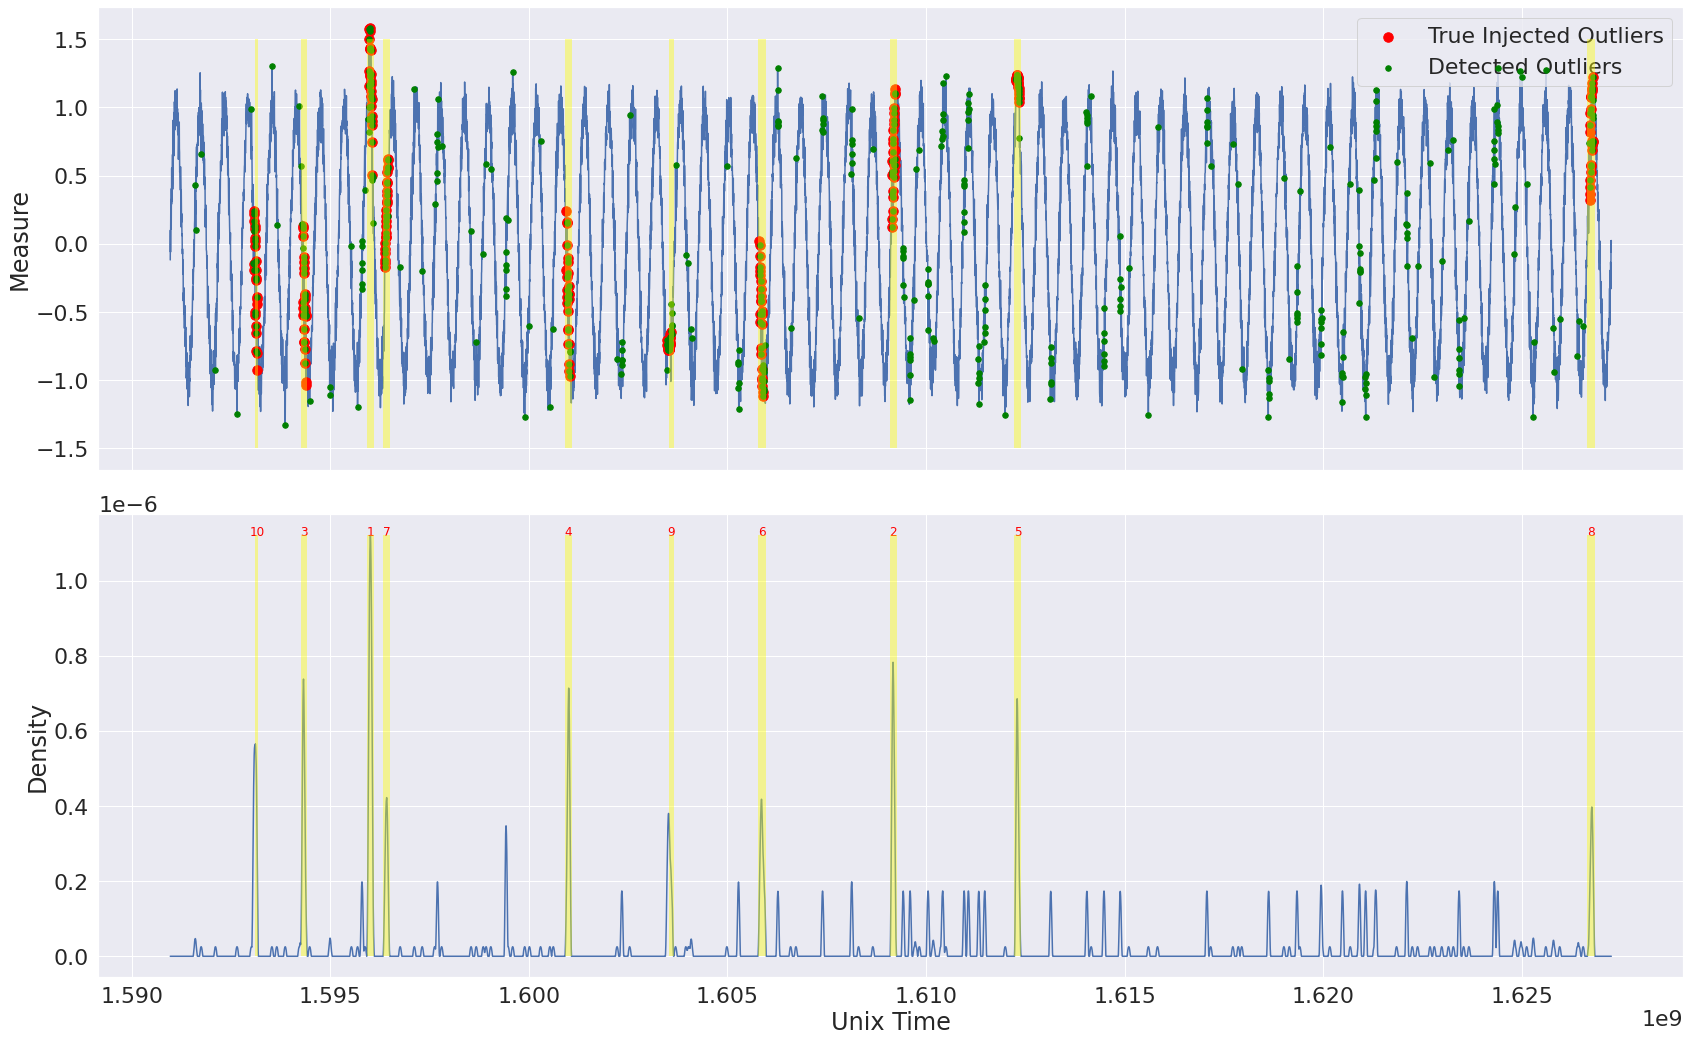

In [9]:
fig = get_timeseries_and_density_figure(df, density_df_ISJ, clusters_df_ISJ, k=10)
fig.savefig('../figures/synthetic_experiments/improved_sheather_jones/example_top_k_alerts_using_isj_bandwidth.svg')
fig

### Evaluation Comparing Fixed Bandwidth vs ISJ Bandwidth

In [9]:
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df)
recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
print("Using Fixed Bandwidth (Full Bounds):")
print('Precision:', precision, 'Recall:', recall, '\n')



real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=True)
recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
print("Using Fixed Bandwidth (Tight Bounds):")
print('Precision:', precision, 'Recall:', recall, '\n')

Using Fixed Bandwidth (Full Bounds):
Precision: 0.11354263677662539 Recall: 1.0 

Using Fixed Bandwidth (Tight Bounds):
Precision: 0.4690396880741415 Recall: 1.0 



In [10]:
real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df_ISJ)
recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
print("Using ISJ Bandwidth (Full Bounds):")
print('Precision:', precision, 'Recall:', recall, '\n')


real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df_ISJ, cluster_points_bounds=True)
recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
print("Using ISJ Bandwidth (Tight Bounds):")
print('Precision:', precision, 'Recall:', recall, '\n')

Using ISJ Bandwidth (Full Bounds):
Precision: 0.47447470454765683 Recall: 1.0 

Using ISJ Bandwidth (Tight Bounds):
Precision: 0.818894265232975 Recall: 1.0 



# All Outlier Types Experiment

In [11]:
def all_outlier_types_experiment(dir_paths, cluster_points_bounds=False):
    precision_list = [];recall_list = []
    precision_isj_list =[];recall_isj_list = []

    for path in tqdm(dir_paths):
        regions_df = pd.read_pickle(path + 'regions_df.pickle')
        df = pd.read_pickle(path + 'df.pickle').sort_values(by='unix_time')
        clusters_df = pd.read_pickle(path + 'clusters_df.pickle').sort_values(by='area', ascending=False)

        # Add unix time to the regions_df
        regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
        regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

        # Compute the range-based precision and recall
        real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=cluster_points_bounds)
        recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
        precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
        precision_list.append(precision);recall_list.append(recall)

        # Get clusters using bandwidth from ISJ 
        density_df_ISJ = get_kde_isj_density_df(df)
        clusters_df_ISJ = get_isj_clusters_df(density_df_ISJ, df)

        # Save the density_df and cluster_df for ISJ in the directory
        density_df_ISJ.to_pickle(path+'density_ISJ_df.pickle')
        clusters_df_ISJ.to_pickle(path+'clusters_ISJ_df.pickle')

        # Save the timeseries_density plot using ISJ bandwidth
        fig = get_timeseries_and_density_figure(df, density_df_ISJ, clusters_df_ISJ, k=len(regions_df.index))
        fig.savefig(path+'figures/timeseries_density_ISJ_plot.svg')  

        # Compute the range-based precision and recall with ISJ bandwidth
        real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df_ISJ, cluster_points_bounds=cluster_points_bounds)
        recall_isj = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
        precision_isj = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
        precision_isj_list.append(precision_isj);recall_isj_list.append(recall_isj)
    
    evaluation_dict = {
        'precision': precision_list, 'recall': recall_list, 'precision_isj': precision_isj_list, 'recall_isj': recall_isj_list, 
        'seed': list(range(1, len(precision_list) + 1))
    }
    evaluation_df = pd.DataFrame.from_dict(evaluation_dict)
    evaluation_df['f1_score'] = (2 * evaluation_df['precision'].to_numpy() * evaluation_df['recall'].to_numpy()) / (evaluation_df['precision'].to_numpy() + evaluation_df['recall'].to_numpy())
    evaluation_df['f1_score_isj'] = (2 * evaluation_df['precision_isj'].to_numpy() * evaluation_df['recall_isj'].to_numpy()) / (evaluation_df['precision_isj'].to_numpy() + evaluation_df['recall_isj'].to_numpy())


    return evaluation_df

## Full Bounds

In [12]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/all_outlier_types_098/*/"))
evaluation_df = all_outlier_types_experiment(dir_paths)

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


In [13]:
print("Fixed Bandwidth Evaluation:")
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision'].mean(), evaluation_df['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall'].mean(), evaluation_df['recall'].std())
print("Mean/SDEV F1-Score:", evaluation_df['f1_score'].mean(), evaluation_df['f1_score'].std())
print('\n')


print("ISJ Bandwidth Evaluation:")
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision_isj'].mean(), evaluation_df['precision_isj'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall_isj'].mean(), evaluation_df['recall_isj'].std())
print("Mean/SDEV F1-Score:", evaluation_df['f1_score_isj'].mean(), evaluation_df['f1_score_isj'].std())

Fixed Bandwidth Evaluation:
Mean/SDEV: Range-Based Precision: 0.10909035144045834 0.012797052758775851
Mean/SDEV Range-Based Recall: 0.9800000000000001 0.06324555320336758
Mean/SDEV F1-Score: 0.19613333845508127 0.021134643536243104


ISJ Bandwidth Evaluation:
Mean/SDEV: Range-Based Precision: 0.4946533805401305 0.023979210056812174
Mean/SDEV Range-Based Recall: 0.9400000000000001 0.06992058987801009
Mean/SDEV F1-Score: 0.6473601918936579 0.029475685209234985


## Tight Bounds

In [14]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/all_outlier_types_098/*/"))
evaluation_df = all_outlier_types_experiment(dir_paths, cluster_points_bounds=True)

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


In [15]:
print("Fixed Bandwidth Evaluation:")
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision'].mean(), evaluation_df['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall'].mean(), evaluation_df['recall'].std())
print("Mean/SDEV F1-Score:", evaluation_df['f1_score'].mean(), evaluation_df['f1_score'].std())
print('\n')


print("ISJ Bandwidth Evaluation:")
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision_isj'].mean(), evaluation_df['precision_isj'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall_isj'].mean(), evaluation_df['recall_isj'].std())
print("Mean/SDEV F1-Score:", evaluation_df['f1_score_isj'].mean(), evaluation_df['f1_score_isj'].std())

Fixed Bandwidth Evaluation:
Mean/SDEV: Range-Based Precision: 0.42344772768866523 0.059232193621522176
Mean/SDEV Range-Based Recall: 0.9800000000000001 0.06324555320336758
Mean/SDEV F1-Score: 0.5887018154746894 0.06131580676522617


ISJ Bandwidth Evaluation:
Mean/SDEV: Range-Based Precision: 0.8859559537907217 0.0456851422085304
Mean/SDEV Range-Based Recall: 0.9400000000000001 0.06992058987801009
Mean/SDEV F1-Score: 0.9104210494557563 0.040709931895282846


# Injection Rate Experiment

In [16]:
def injection_rate_experiment(dir_paths, cluster_points_bounds=False):
    precision_list = [];recall_list = []
    precision_isj_list =[];recall_isj_list = []
    injection_rate_list = []

    for path in tqdm(dir_paths):
        dir_paths_local = sorted(glob(path+'/*/'))

        temp_precision = [];temp_recall = []
        temp_isj_precision=[];temp_isj_recall=[]
        injection_rate = os.path.basename(os.path.dirname(path)).split('_')[1]
        
        for path_local in dir_paths_local:

            regions_df = pd.read_pickle(path_local + 'regions_df.pickle')
            df = pd.read_pickle(path_local + 'df.pickle').sort_values(by='unix_time')
            clusters_df = pd.read_pickle(path_local + 'clusters_df.pickle').sort_values(by='area', ascending=False)

            # Add unix time to the regions_df
            regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
            regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

            # Compute the range-based precision and recall
            real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=cluster_points_bounds)
            recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
            precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
            temp_precision.append(precision);temp_recall.append(recall)

            # Get clusters using bandwidth from ISJ 
            density_df_ISJ = get_kde_isj_density_df(df)
            clusters_df_ISJ = get_isj_clusters_df(density_df_ISJ, df)

            # Save the density_df and cluster_df for ISJ in the directory
            density_df_ISJ.to_pickle(path_local+'density_ISJ_df.pickle')
            clusters_df_ISJ.to_pickle(path_local+'clusters_ISJ_df.pickle')

            # Save the timeseries_density plot using ISJ bandwidth
            fig = get_timeseries_and_density_figure(df, density_df_ISJ, clusters_df_ISJ, k=len(regions_df.index))
            fig.savefig(path_local+'figures/timeseries_density_ISJ_plot.svg')  

            # Compute the range-based precision and recall with ISJ bandwidth
            real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df_ISJ, cluster_points_bounds=cluster_points_bounds)
            recall_isj = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
            precision_isj = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
            temp_isj_precision.append(precision_isj);temp_isj_recall.append(recall_isj)
        
        # Compute the mean precision and recall at each injection rate
        precision_list.append(np.mean(temp_precision));recall_list.append(np.mean(temp_recall))
        precision_isj_list.append(np.mean(temp_isj_precision));recall_isj_list.append(np.mean(temp_isj_recall))

        injection_rate_list.append(injection_rate)


    evaluation_dict = {
        'precision': precision_list, 'recall': recall_list,
        'precision_isj': precision_isj_list, 'recall_isj': recall_isj_list, 'injection_rate': injection_rate_list
    }

    evaluation_df = pd.DataFrame.from_dict(evaluation_dict)
    f1_scores = (2 * np.array(precision_list) * np.array(recall_list)) / (np.array(precision_list) + np.array(recall_list))
    f1_scores_inj = (2 * np.array(precision_isj_list) * np.array(recall_isj_list)) / (np.array(precision_isj_list) + np.array(recall_isj_list))
    evaluation_df['f1_score'] = f1_scores
    evaluation_df['f1_score_inj'] = f1_scores_inj

    return evaluation_df

## Full Cluster Bounds

In [17]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/injection_rate_098/*/"))
evaluation_df = injection_rate_experiment(dir_paths, cluster_points_bounds=False)
evaluation_df

100%|██████████| 15/15 [00:54<00:00,  3.66s/it]


,precision,recall,precision_isj,recall_isj,injection_rate,f1_score,f1_score_inj
0,0.074274,0.62,0.200967,0.52,0.30,0.132657,0.289896
1,0.079102,0.64,0.273415,0.66,0.35,0.140801,0.386653
2,0.077092,0.66,0.284362,0.66,0.40,0.138057,0.397472
3,0.079518,0.68,0.321825,0.68,0.45,0.142385,0.436885
4,0.077968,0.68,0.326599,0.72,0.50,0.139896,0.449363
5,0.091940,0.82,0.410144,0.84,0.55,0.165342,0.551170
6,0.098396,0.88,0.389222,0.78,0.60,0.177002,0.519308
7,0.091713,0.86,0.401745,0.80,0.65,0.165750,0.534882
8,0.091530,0.86,0.432688,0.90,0.70,0.165452,0.584411
9,0.097319,0.90,0.454958,0.94,0.75,0.175644,0.613152


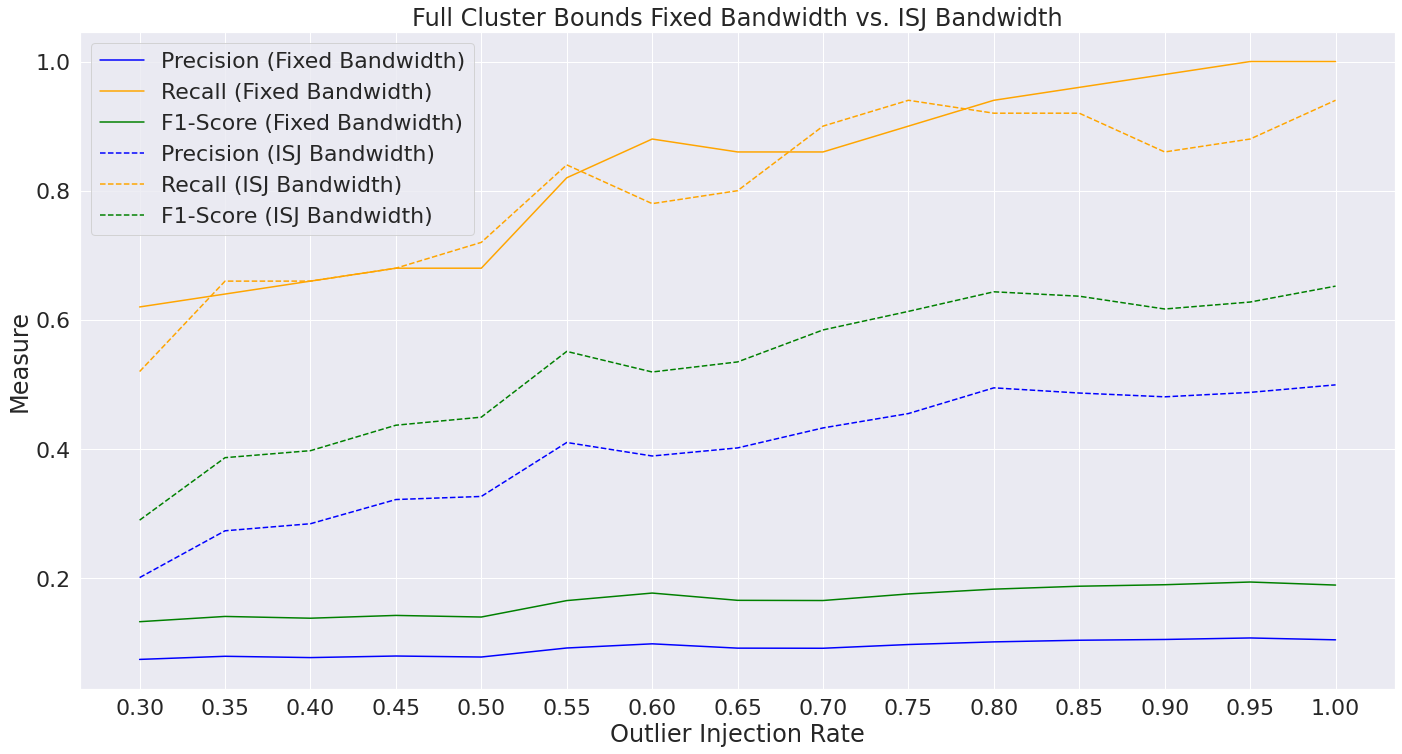

In [33]:
plt.plot(evaluation_df['injection_rate'], evaluation_df['precision'], color='blue', label='Precision (Fixed Bandwidth)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['recall'], color='orange', label='Recall (Fixed Bandwidth)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['f1_score'], color='green', label='F1-Score (Fixed Bandwidth)')

plt.plot(evaluation_df['injection_rate'], evaluation_df['precision_isj'], '--', color='blue', label='Precision (ISJ Bandwidth)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['recall_isj'], '--', color='orange', label='Recall (ISJ Bandwidth)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['f1_score_inj'], '--', color='green', label='F1-Score (ISJ Bandwidth)')

plt.xlabel('Outlier Injection Rate');plt.ylabel('Measure');plt.legend();plt.title('Full Cluster Bounds Fixed Bandwidth vs. ISJ Bandwidth');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/improved_sheather_jones/outlier_injection_rate_full_cluster_bounds.svg')

## Tight Cluster Bounds

In [34]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/injection_rate_098/*/"))
evaluation_tight_df = injection_rate_experiment(dir_paths, cluster_points_bounds=True)

100%|██████████| 15/15 [00:40<00:00,  2.69s/it]


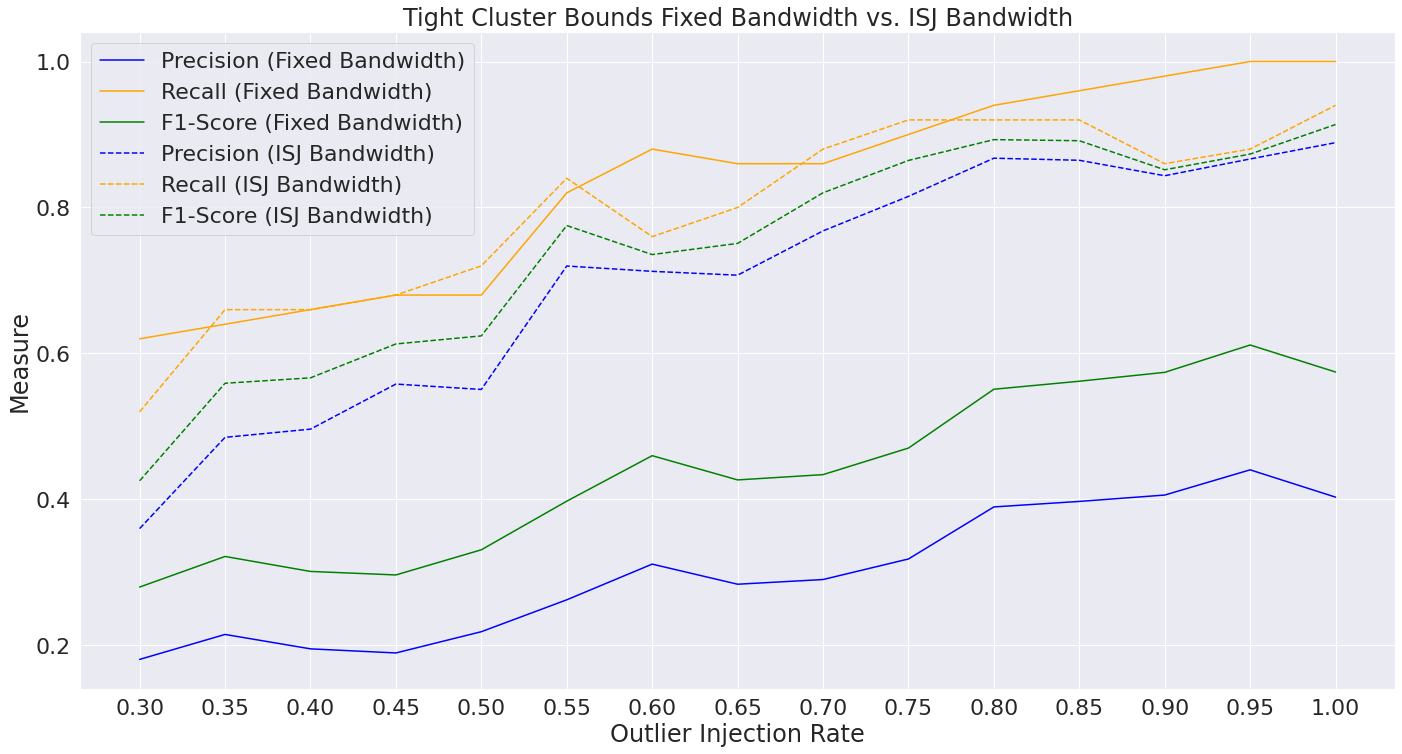

In [35]:
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['precision'], color='blue', label='Precision (Fixed Bandwidth)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['recall'], color='orange', label='Recall (Fixed Bandwidth)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['f1_score'], color='green', label='F1-Score (Fixed Bandwidth)')

plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['precision_isj'], '--', color='blue', label='Precision (ISJ Bandwidth)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['recall_isj'], '--', color='orange', label='Recall (ISJ Bandwidth)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['f1_score_inj'], '--', color='green', label='F1-Score (ISJ Bandwidth)')

plt.xlabel('Outlier Injection Rate');plt.ylabel('Measure');plt.legend();plt.title('Tight Cluster Bounds Fixed Bandwidth vs. ISJ Bandwidth');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/improved_sheather_jones/outlier_injection_rate_tight_cluster_bounds.svg')

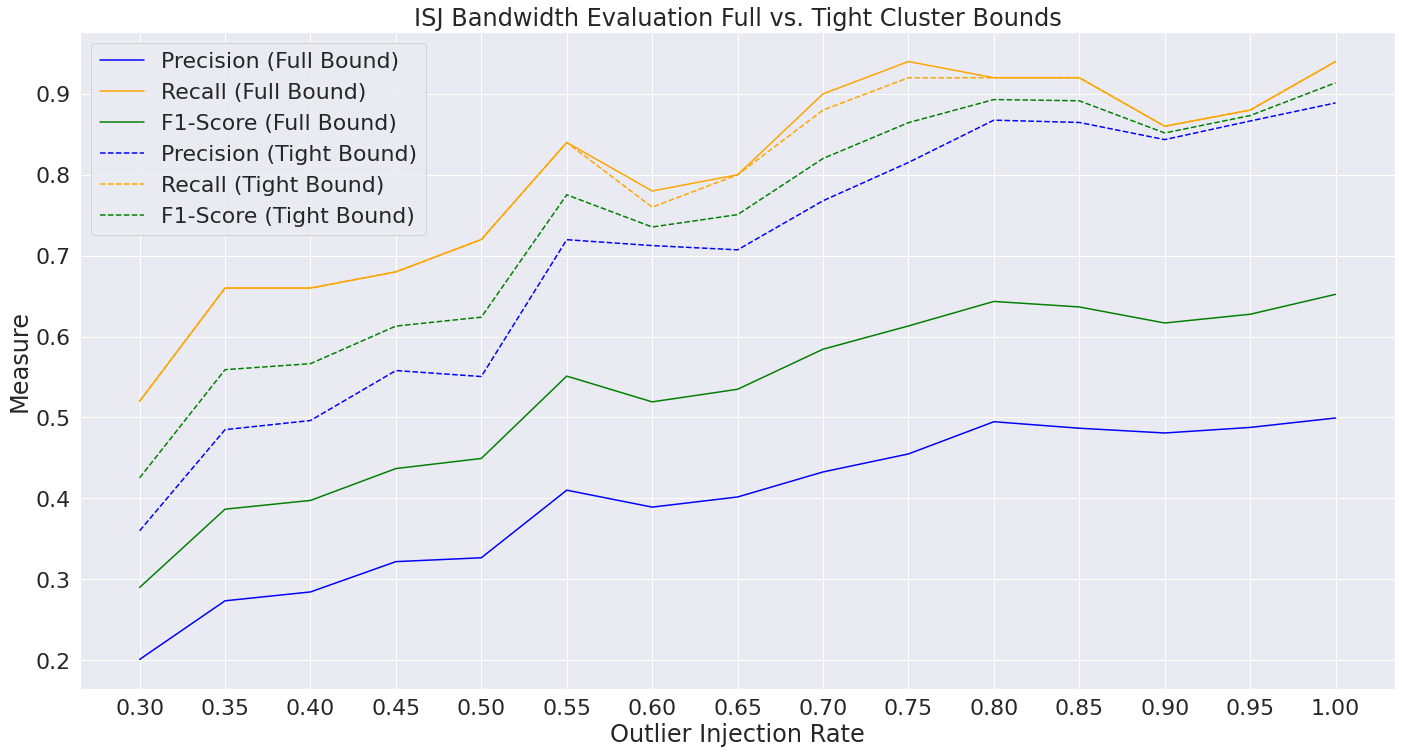

In [37]:
plt.plot(evaluation_df['injection_rate'], evaluation_df['precision_isj'], color='blue', label='Precision (Full Bound)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['recall_isj'], color='orange', label='Recall (Full Bound)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['f1_score_inj'], color='green', label='F1-Score (Full Bound)')

plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['precision_isj'], '--', color='blue', label='Precision (Tight Bound)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['recall_isj'], '--', color='orange', label='Recall (Tight Bound)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['f1_score_inj'], '--', color='green', label='F1-Score (Tight Bound)')

plt.xlabel('Outlier Injection Rate');plt.ylabel('Measure');plt.legend();plt.title('ISJ Bandwidth Evaluation Full vs. Tight Cluster Bounds');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/improved_sheather_jones/outlier_injection_rate_ISJ_bandwidth_full_vs_tight_bounds.svg')

# Equidepth Histogram

## Functions

In [143]:
def get_quantiles(points, num_clusters=None, num_points_per_cluster=None):
    '''
    Returns the quantiles to be used for the construction of the equidepth histogram

    Either `num_clusters` or `num_points_per_cluster` should be specified but not both
    '''

    # Ensure input arguments are correctly specified
    if num_clusters == None and num_points_per_cluster == None:
        raise ValueError("Neither 'num_clusters' nor 'num_points_per_cluster' was specified")
    elif num_clusters and num_points_per_cluster:
        raise ValueError("Only one of 'num_clusters' or 'num_points_per_cluster' should be specified, not both!")
    

    quantiles = [0]
    if num_clusters:
        for i in range(1, num_clusters):
            quantiles.append(i/num_clusters)
    elif num_points_per_cluster:
        quantile_per_cluster = num_points_per_cluster / len(points)
        num_clusters = math.ceil(len(points) / num_points_per_cluster)
        for i in range(1, num_clusters):
            quantiles.append(quantiles[-1] + quantile_per_cluster)
    quantiles.append(1)

    return quantiles

def get_equidepth_histogram_clusters_df(cluster_boundaries):
    data = {'cluster_id': [], 'start': [], 'end': [], 'time_length': []}

    for i in range(1, len(cluster_boundaries) - 1):        
        data['cluster_id'].append(i)
        data['start'].append(cluster_boundaries[i])
        data['end'].append(cluster_boundaries[i+1])
        data['time_length'].append(cluster_boundaries[i+1] - cluster_boundaries[i])
    
    clusters_df = pd.DataFrame.from_dict(data)
    return clusters_df

## Illustrative Example

In [144]:
dir_path = "../synthetic_data/synthetic_experiments/all_outlier_types_098/seed2/"

df = pd.read_pickle(dir_path + 'df.pickle').sort_values(by='unix_time')
clusters_df = pd.read_pickle(dir_path + 'clusters_df.pickle').sort_values(by='area', ascending=False)
regions_df = pd.read_pickle(dir_path + 'regions_df.pickle')
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

### 24 points per cluster

In [145]:
# Get outlier timestamps only from the raw level
outlier_timestamps = sorted(list(set(get_outlier_timestamps(df))))

# Get the cluster boundaries using equidepth histograms
quantiles = get_quantiles(points=outlier_timestamps, num_points_per_cluster=24)
cluster_boundaries = stats.mstats.mquantiles(outlier_timestamps, prob=quantiles)
eq_histogram_clusters_df = get_equidepth_histogram_clusters_df(cluster_boundaries)

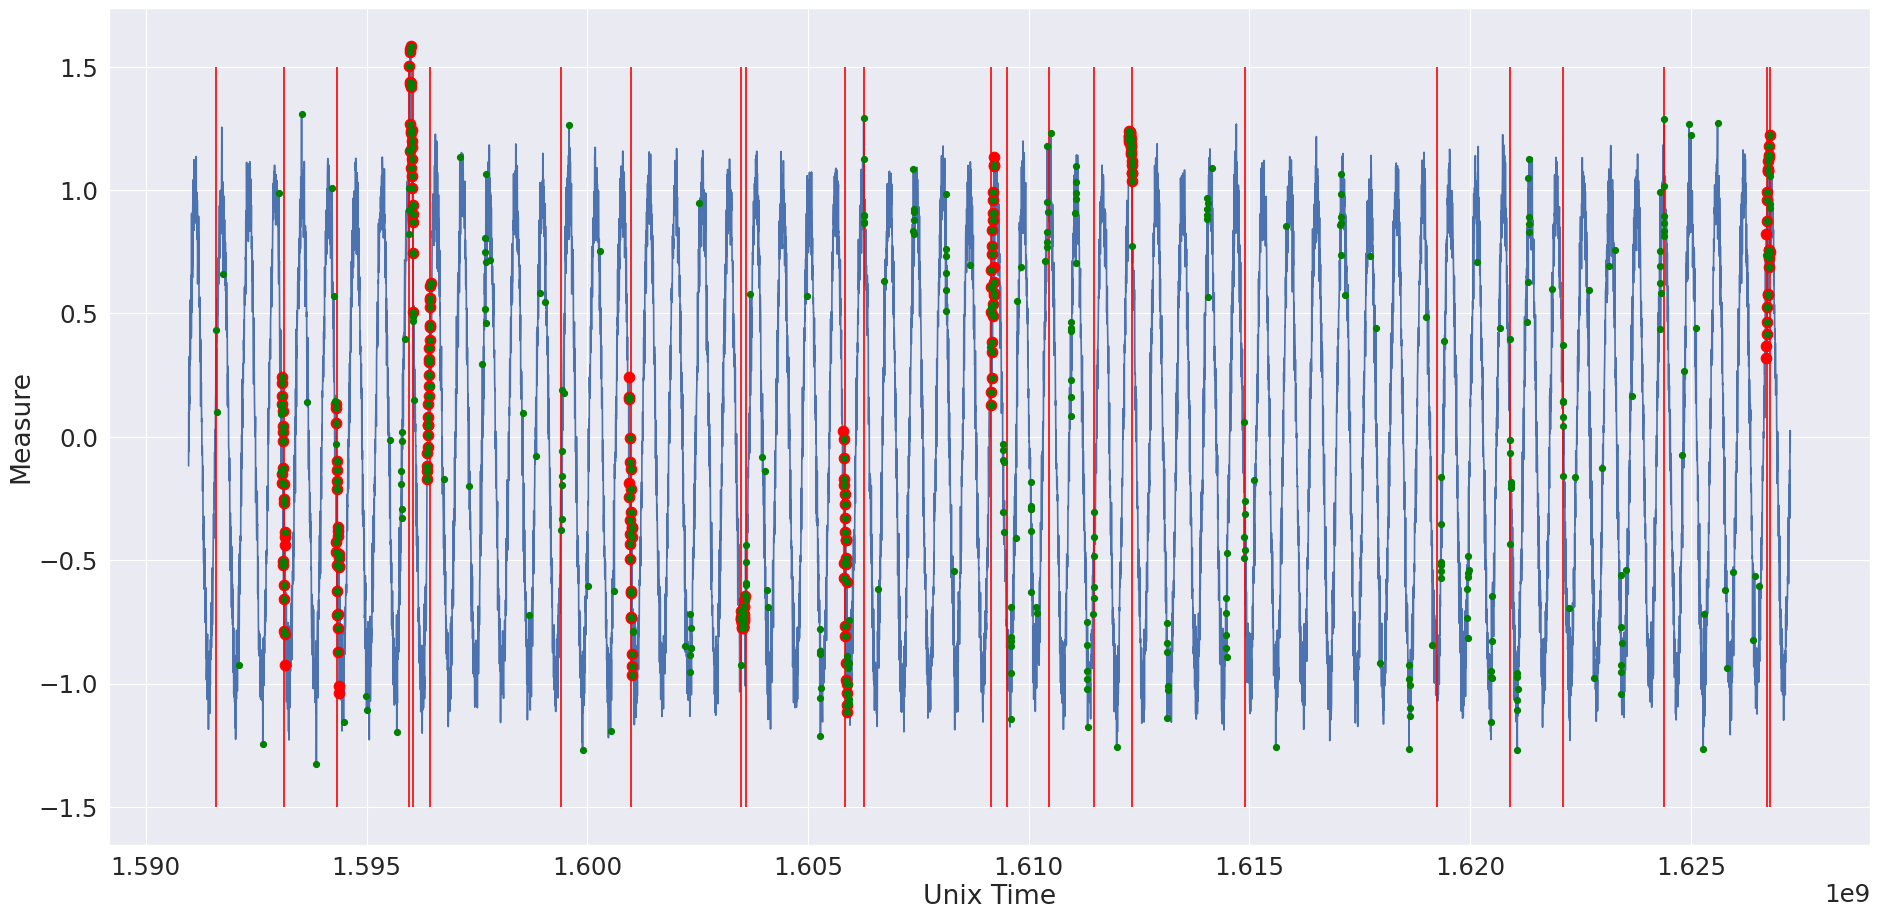

In [151]:
figure(figsize=(24, 12), dpi=80)

plt.plot(df['unix_time'], df['measure'])
plt.scatter(df[df['is_outlier']==1]['unix_time'].values, df[df['is_outlier']==1]['measure'].values, s=90, c='red', zorder=10, label='True Injected Outliers')
plt.scatter(outlier_timestamps, df[df['unix_time'].isin(outlier_timestamps)]['measure'].values, s=30, c='green', zorder=11, label='Detected Outliers')
plt.vlines(cluster_boundaries, -1.5, 1.5, colors='red', zorder=10)
plt.xlabel('Unix Time');plt.ylabel('Measure');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/equidepth_histograms/24_points_per_cluster.svg')

In [152]:
# Sort clusters by their length (choose the most tight clusters)
eq_histogram_clusters_df = eq_histogram_clusters_df.sort_values(by='time_length')

In [153]:
real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, eq_histogram_clusters_df.head(10))
recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
print("Using Equidepth Histograms with 24 points per cluster:")
print('Precision:', precision, 'Recall:', recall, '\n')

Using Equidepth Histograms with 24 points per cluster:
Precision: 0.28922762545972147 Recall: 0.7 



### 10 equal sized clusters

In [154]:
# Get outlier timestamps only from the raw level
outlier_timestamps = sorted(list(set(get_outlier_timestamps(df))))

# Get the cluster boundaries using equidepth histograms
quantiles = get_quantiles(points=outlier_timestamps, num_clusters=10)
cluster_boundaries = stats.mstats.mquantiles(outlier_timestamps, prob=quantiles)
eq_histogram_clusters_df = get_equidepth_histogram_clusters_df(cluster_boundaries)

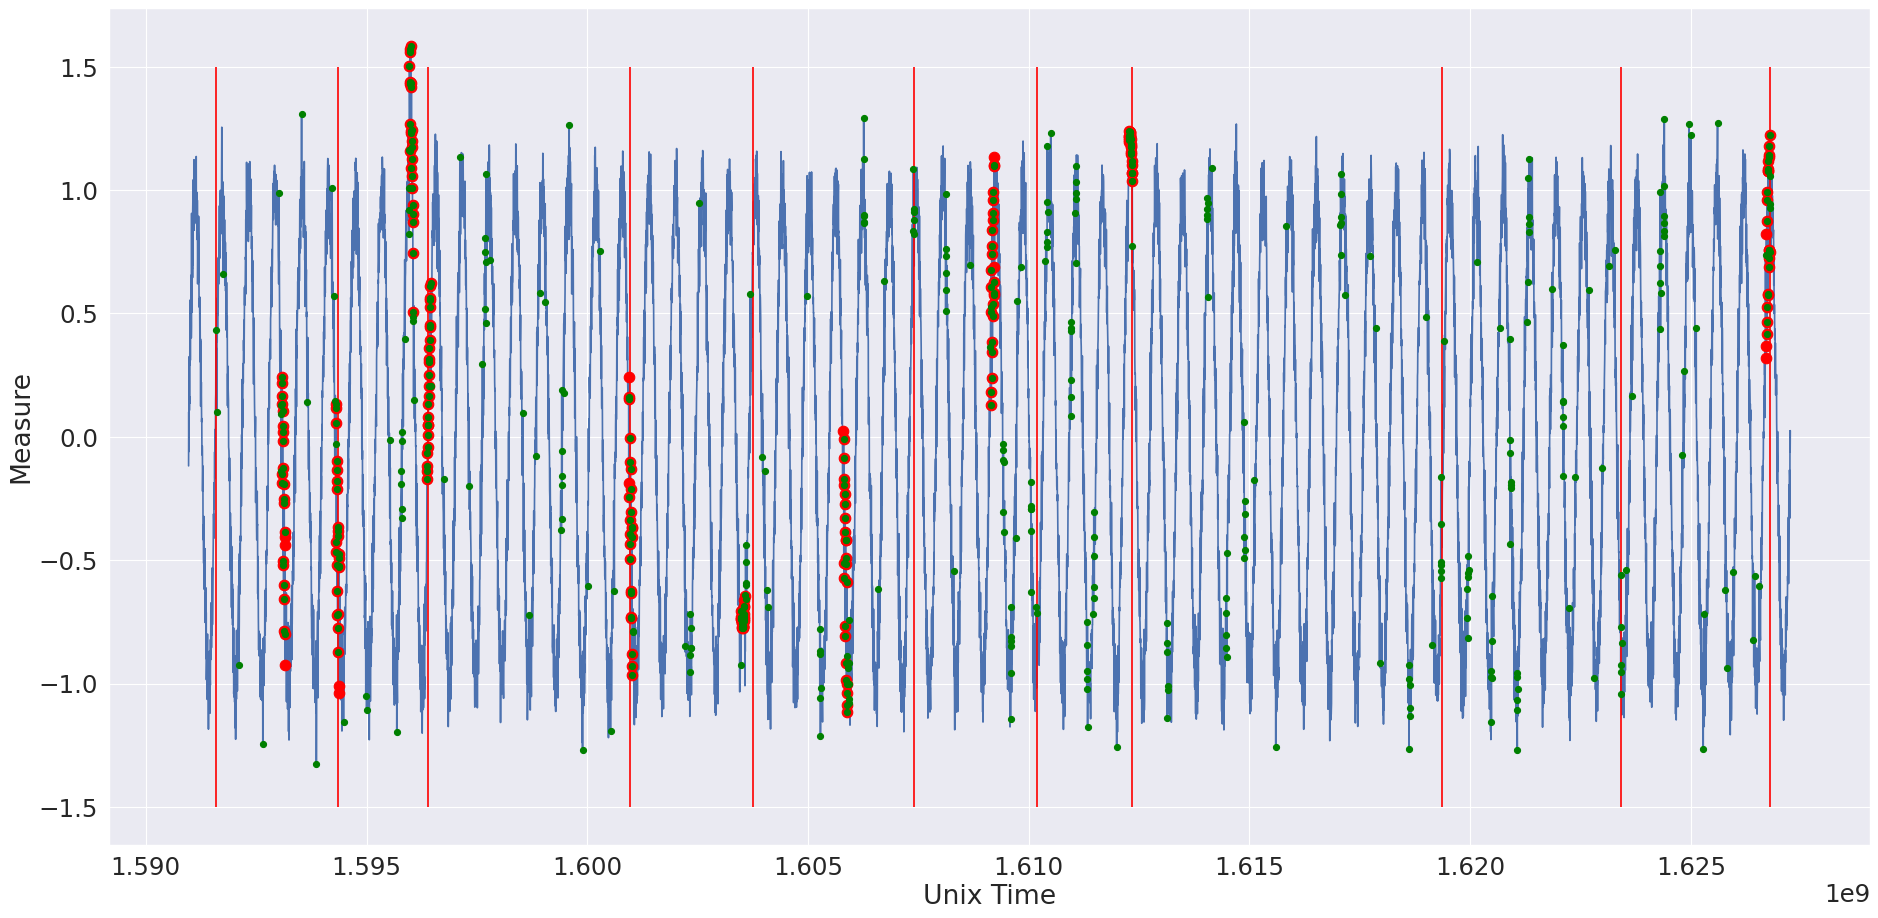

In [155]:
figure(figsize=(24, 12), dpi=80)
plt.plot(df['unix_time'], df['measure'])
plt.scatter(df[df['is_outlier']==1]['unix_time'].values, df[df['is_outlier']==1]['measure'].values, s=90, c='red', zorder=10, label='True Injected Outliers')
plt.scatter(outlier_timestamps, df[df['unix_time'].isin(outlier_timestamps)]['measure'].values, s=30, c='green', zorder=11, label='Detected Outliers')
plt.vlines(cluster_boundaries, -1.5, 1.5, colors='red', zorder=10)
plt.xlabel('Unix Time');plt.ylabel('Measure');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/equidepth_histograms/10_equal_sized_clusters.svg')

In [156]:
real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, eq_histogram_clusters_df.head(10))
recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
print("Using Equidepth Histograms that generate a total of 10 clusters:")
print('Precision:', precision, 'Recall:', recall, '\n')

Using Equidepth Histograms that generate a total of 10 clusters:
Precision: 0.018864457699749565 Recall: 0.9 



## All Outlier Types Experiment

In [164]:
def all_outlier_types_experiment_eq_histogram(dir_paths, cluster_points_bounds=False, num_clusters=None, num_points_per_cluster=None):
    precision_list = [];recall_list = []

    for path in tqdm(dir_paths):
        regions_df = pd.read_pickle(path + 'regions_df.pickle')
        df = pd.read_pickle(path + 'df.pickle').sort_values(by='unix_time')
        clusters_df = pd.read_pickle(path + 'clusters_df.pickle').sort_values(by='area', ascending=False)

        # Add unix time to the regions_df
        regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
        regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

        # Get outlier timestamps only from the raw level
        outlier_timestamps = sorted(list(set(get_outlier_timestamps(df))))

        # Get the cluster boundaries using equidepth histograms
        quantiles = get_quantiles(points=outlier_timestamps, num_clusters=num_clusters, num_points_per_cluster=num_points_per_cluster)
        cluster_boundaries = stats.mstats.mquantiles(outlier_timestamps, prob=quantiles)
        eq_histogram_clusters_df = get_equidepth_histogram_clusters_df(cluster_boundaries)
        eq_histogram_clusters_df = eq_histogram_clusters_df.sort_values(by='time_length')

        real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, eq_histogram_clusters_df, cluster_points_bounds=cluster_points_bounds)
        recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
        precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
        precision_list.append(precision);recall_list.append(recall)
    
    evaluation_dict = {
        'precision': precision_list, 'recall': recall_list, 'seed': list(range(1, len(precision_list) + 1))
    }
    evaluation_df = pd.DataFrame.from_dict(evaluation_dict)
    evaluation_df['f1_score'] = (2 * evaluation_df['precision'].to_numpy() * evaluation_df['recall'].to_numpy()) / (evaluation_df['precision'].to_numpy() + evaluation_df['recall'].to_numpy())

    return evaluation_df

### Full Bounds

In [167]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/all_outlier_types_098/*/"))
evaluation_df_24_ppc = all_outlier_types_experiment_eq_histogram(dir_paths, cluster_points_bounds=False, num_points_per_cluster=24)
evaluation_df_10_esc = all_outlier_types_experiment_eq_histogram(dir_paths, cluster_points_bounds=False, num_clusters=10)

100%|██████████| 10/10 [00:00<00:00, 27.04it/s]


In [168]:
print("Full Bounds 24 points per cluster:")
print("Mean/SDEV: Range-Based Precision:", evaluation_df_24_ppc['precision'].mean(), evaluation_df_24_ppc['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df_24_ppc['recall'].mean(), evaluation_df_24_ppc['recall'].std())
print("Mean/SDEV F1-Score:", evaluation_df_24_ppc['f1_score'].mean(), evaluation_df_24_ppc['f1_score'].std())
print('\n')

print("Full Bounds 10 Equally Sized Clusters:")
print("Mean/SDEV: Range-Based Precision:", evaluation_df_10_esc['precision'].mean(), evaluation_df_10_esc                                                                                                                       ['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df_10_esc['recall'].mean(), evaluation_df_10_esc['recall'].std())
print("Mean/SDEV F1-Score:", evaluation_df_10_esc['f1_score'].mean(), evaluation_df_10_esc['f1_score'].std())

Full Bounds 24 points per cluster:
Mean/SDEV: Range-Based Precision: 0.0927853763903545 0.07732554703777714
Mean/SDEV Range-Based Recall: 0.8400000000000001 0.11737877907772674
Mean/SDEV F1-Score: 0.1560440598284334 0.10443349086105846


Full Bounds 10 Equally Sized Clusters:
Mean/SDEV: Range-Based Precision: 0.022859235934975526 0.004737146694290281
Mean/SDEV Range-Based Recall: 0.9 0.047140452079103154
Mean/SDEV F1-Score: 0.0445466616690722 0.009011921141454948
